利用python3的 photutils 程序包以代码的形式，展示如何对HST/EGS 星系巡天图像进行读取、选源、测光、生成catalog、生成image cutout 产品。

###############


从python3 中载入所需的函数。

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.segmentation import (detect_threshold,deblend_sources,SourceCatalog,make_2dgaussian_kernel,detect_sources)
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.segmentation import make_2dgaussian_kernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

读取我们的fits图像： 包括 image 和 header

In [2]:
file=fits.open('demo_egs.fits')

查看这个fits 文件的层数

In [4]:
file.info()

Filename: demo_egs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    5359   (2000, 2000)   float32   


查看fits文件的图像, i.e., data。 图像=二维数组

In [5]:
data=file[0].data
data

array([[ 0.00286317,  0.00303189,  0.00013026, ...,  0.00590488,
         0.00309897, -0.00046303],
       [-0.00019335, -0.00020625, -0.0021195 , ...,  0.00013581,
        -0.00044395, -0.00288404],
       [-0.00372648, -0.00452932, -0.00973264, ..., -0.00116039,
        -0.00224781, -0.0024908 ],
       ...,
       [ 0.0033864 ,  0.00023902,  0.00288464, ..., -0.00160417,
        -0.00055423,  0.00109951],
       [ 0.00422823,  0.00508487,  0.00922502, ..., -0.00048484,
         0.00238961, -0.00085411],
       [ 0.00452221,  0.00969143,  0.01198754, ...,  0.00046502,
         0.0023102 , -0.00130063]], dtype=float32)

查看此图像的大小

In [493]:
data.shape

(2000, 2000)

看看这个图像长什么样子。

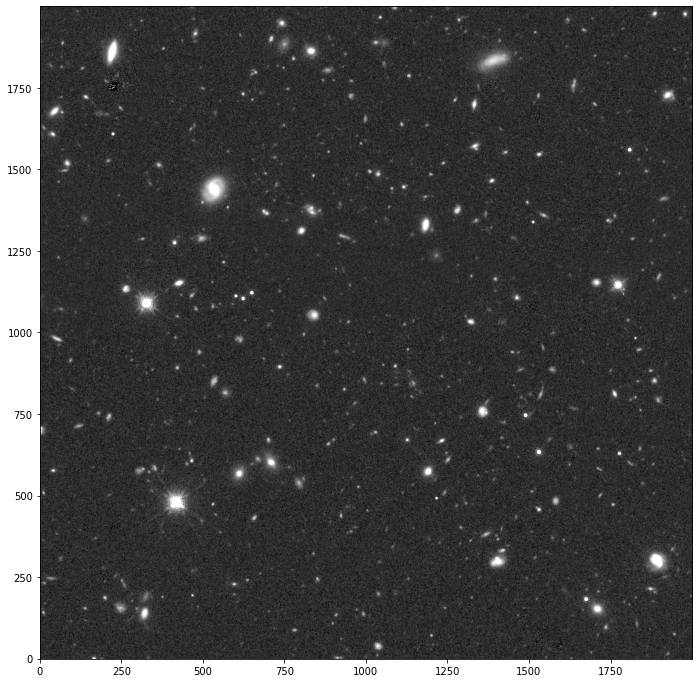

In [6]:
norm=simple_norm(data,stretch='asinh',min_cut=-0.01, max_cut=0.17)
plt.figure(figsize=(12,12))
plt.imshow(data,cmap='gray',norm=norm,origin='lower')

读取header中的全部信息。

In [44]:
header=file[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2000                                                  
NAXIS2  =                 2000                                                  
FILENAME= 'hlsp_candels_hst_wfc3_egs-tot-60mas_f160w_v1.0_drz.fits' / MAST HLSP 
OBJECT  = 'EGS_ALL_WFC3_IR_F160W_060MAS_V1.1_DRZ[1/1]'                          
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '2014-07-22T15:14:41'                                                 
IRAFNAME= 'egs_all_wfc3_ir_f160w_060mas_v1.1_drz.hhh'  /  NAME OF IRAF IMAGE FIL
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000E0  /  DATA MIN                                     
IRAF-BPX=                   

罗列header中关键词（）

In [496]:
list(header.keys())

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'FILENAME',
 'OBJECT',
 'ORIGIN',
 'DATE',
 'IRAFNAME',
 'IRAF-MAX',
 'IRAF-MIN',
 'IRAF-BPX',
 'IRAFTYPE',
 'DATAMIN',
 'DATAMAX',
 'CRPIX1',
 'CRVAL1',
 'CTYPE1',
 'CD1_1',
 'CD2_1',
 'CRPIX2',
 'CRVAL2',
 'CTYPE2',
 'CD1_2',
 'CD2_2',
 'ORIGIN',
 'DATE',
 'FILETYPE',
 '',
 'TELESCOP',
 'INSTRUME',
 'EQUINOX',
 '',
 '',
 '',
 'ROOTNAME',
 'IMAGETYP',
 'PRIMESI',
 '',
 '',
 '',
 'TARGNAME',
 'RA_TARG',
 'DEC_TARG',
 '',
 '',
 '',
 'PROPOSID',
 'LINENUM',
 'PR_INV_L',
 'PR_INV_F',
 'PR_INV_M',
 '',
 '',
 '',
 'SUNANGLE',
 'MOONANGL',
 'SUN_ALT',
 'FGSLOCK',
 'GYROMODE',
 'REFFRAME',
 'MTFLAG',
 '',
 'DATE-OBS',
 'TIME-OBS',
 'EXPSTART',
 'EXPEND',
 'EXPTIME',
 'EXPFLAG',
 'QUALCOM1',
 'QUALCOM2',
 'QUALCOM3',
 'QUALITY',
 '',
 '',
 '',
 '',
 'PA_V3',
 '',
 '',
 '',
 'POSTARG1',
 'POSTARG2',
 '',
 '',
 '',
 'OPUS_VER',
 'CAL_VER',
 'PROCTIME',
 '',
 '',
 '',
 'OBSTYPE',
 'OBSMODE',
 'SCLAMP',
 'NRPTEXP',
 'SUBARRAY',
 'SUBTYPE',
 'D

其中的很多关键词keywords 非常重要，比如：

In [250]:
header['TELESCOP']

'HST'

In [251]:
header['INSTRUME']

'WFC3'

In [252]:
header['FILTER']

'F160W'

In [253]:
header['PHOTMODE']

'WFC3 IR F160W'

In [254]:
header['PHOTPLAM']

15369.176

In [255]:
header['TARGNAME']

'EGS-V0O'

In [256]:
header['EXPTIME']

159257.8

In [257]:
header['BUNIT']

'ELECTRONS/S'

利用阈值（thresholding）方法来提取属于天体目标的pixels

首先获得 thresholding image.

In [488]:
threshold=detect_threshold(data,nsigma=3)  # threshold 2D image
print (threshold.shape)
threshold

(2000, 2000)


array([[0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341],
       [0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341],
       [0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341],
       ...,
       [0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341],
       [0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341],
       [0.01112341, 0.01112341, 0.01112341, ..., 0.01112341, 0.01112341,
        0.01112341]])

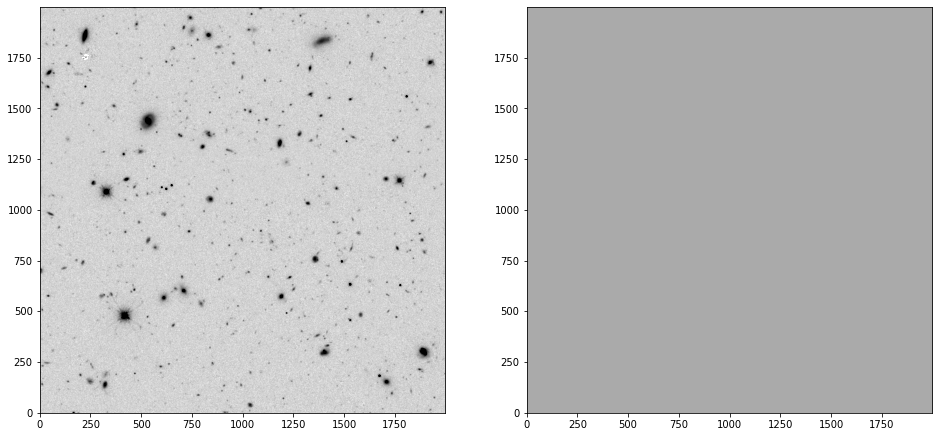

In [11]:
threshold=detect_threshold(data,nsigma=3) # determine the threshold image
plt.figure(figsize=(16,16))
ax1=plt.subplot(121)
plt.imshow(data,cmap='gray_r',norm=norm,origin='lower')

ax2=plt.subplot(122)
plt.imshow(threshold,cmap='gray_r',norm=norm,origin='lower')

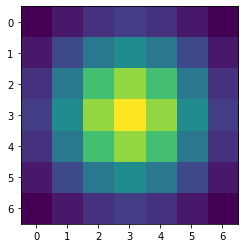

In [9]:
kernel=make_2dgaussian_kernel(fwhm=4,size=7) # FWHM=4.  This value is similar to the F160W PSF FWHM
kernel.array
plt.imshow(kernel.array)

利用 thresholding image 来判定哪些pixel 将被归类为属于天体: thresholding

Text(0.5, 1.0, 'Segmentation map')

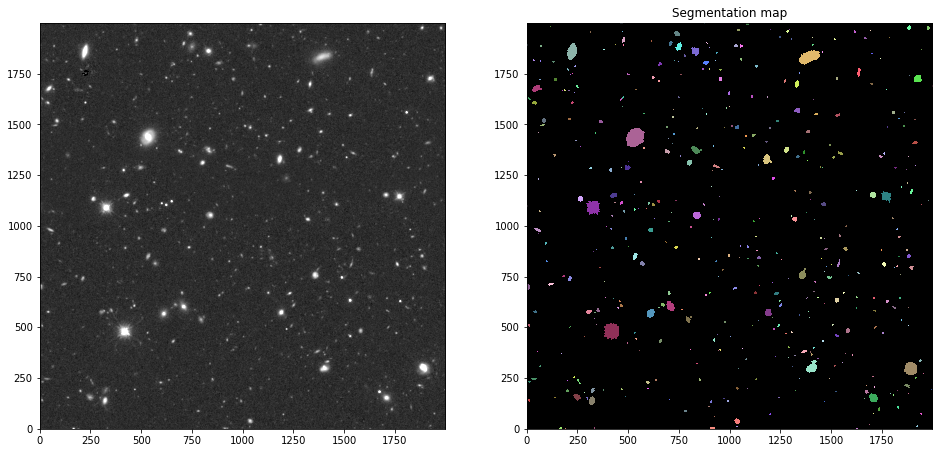

In [14]:
plt.figure(figsize=(16,16))
segm=detect_sources(data, threshold, npixels=10, kernel=kernel) # using thresholding to select pixels belong to object 
ax1=plt.subplot(121)
ax1.imshow(data,cmap='gray',origin='lower',norm=norm)

ax2=plt.subplot(122)
ax2.imshow(segm,cmap=segm.cmap,origin='lower',interpolation='nearest')
plt.title('Segmentation map')

源的分离：deblend connected pixels. 生成deblended segement image.

  0%|          | 0/414 [00:00<?, ?it/s]

Text(0.5, 1.0, 'deblended segmentation map')

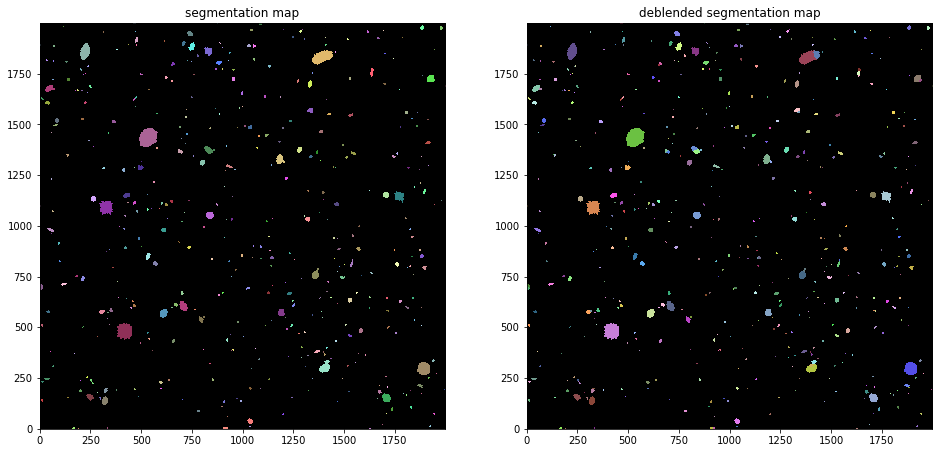

In [15]:
plt.figure(figsize=(16,16))
ax1=plt.subplot(121)
ax1.imshow(segm,cmap=segm.cmap,origin='lower',interpolation='nearest')
plt.title('segmentation map')

ax2=plt.subplot(122)
segm_deblend=deblend_sources(data,segm,npixels=10,kernel=kernel,nlevels=64,contrast=0.01) #npixels=minimum connected pixels; contrast=minum flux fraction
plt.imshow(segm_deblend,cmap=segm_deblend.cmap,origin='lower',interpolation='nearest')
plt.title('deblended segmentation map')

基本deblended segmentation map 和原始图像，生成星系源表：

In [16]:
cat=SourceCatalog(data,segm_deblend,kernel=kernel)
cat.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,165.28163514567657,2.3507302132861314,None,158,172,0,7,105.0,2.877184303251185,1.7790657615063212,-1.3365035641834027,0.785914095708659,0.0029294725973159075,0.36569729447364807,0.0,7.573840867960826,nan,7.920185101042859,nan
2,188.46073063634924,1.3120694288619636,None,185,192,0,3,24.0,1.762111990875677,0.9944774510728446,-0.10008626585562823,0.8255241667825673,0.0057618096470832825,0.033802952617406845,0.0,0.5124926343560219,nan,0.9060480586805959,nan
3,1626.002985513367,1.7539544247103507,None,1623,1629,0,4,28.0,1.7763076956429347,1.149230484205932,-2.457119499583053,0.762509391369363,0.008391288109123707,0.028849143534898758,0.0,0.5737051339820027,nan,0.8721855529087352,nan
4,331.4761020304555,4.305828923397874,None,330,333,2,7,22.0,1.5721979121803016,1.0543634379301319,-89.87820298606763,0.7417918189980983,0.004865825641900301,0.01994624361395836,0.0,0.32446161983534694,nan,0.9834872472843328,nan
5,1549.1818783242798,5.006055410356685,None,1548,1551,4,6,10.0,0.9618243631640742,0.7705316712925765,-1.3992305701605832,0.5985108009891874,0.010694174095988274,0.022554855793714523,0.0,0.1733641093596816,nan,0.7655417043920205,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,231.37439736186923,1785.3871372492326,None,230,233,1784,1787,13.0,1.0562321083006754,0.9115361582118827,43.44222058937863,0.5051912254012837,0.006357894744724035,0.027011848986148834,0.0,0.2310413969680667,nan,0.8026880181053667,nan
506,237.24821253149528,1787.7088368089549,None,234,240,1784,1793,39.0,2.416302040978484,1.3197839383968988,71.47531048399104,0.8376548614249809,0.0023106560111045837,0.025714628398418427,0.0,0.5643568760715425,nan,2.095134974067682,nan


In [18]:
cat.properties 

['area',
 'background',
 'background_centroid',
 'background_ma',
 'background_mean',
 'background_sum',
 'bbox',
 'bbox_xmax',
 'bbox_xmin',
 'bbox_ymax',
 'bbox_ymin',
 'centroid',
 'convdata',
 'convdata_ma',
 'covar_sigx2',
 'covar_sigxy',
 'covar_sigy2',
 'covariance',
 'covariance_eigvals',
 'cutout_centroid',
 'cutout_maxval_index',
 'cutout_minval_index',
 'cxx',
 'cxy',
 'cyy',
 'data',
 'data_ma',
 'eccentricity',
 'ellipticity',
 'elongation',
 'equivalent_radius',
 'error',
 'error_ma',
 'fwhm',
 'gini',
 'inertia_tensor',
 'kron_aperture',
 'kron_flux',
 'kron_fluxerr',
 'kron_radius',
 'label',
 'labels',
 'local_background',
 'local_background_aperture',
 'max_value',
 'maxval_index',
 'maxval_xindex',
 'maxval_yindex',
 'min_value',
 'minval_index',
 'minval_xindex',
 'minval_yindex',
 'moments',
 'moments_central',
 'orientation',
 'perimeter',
 'segment',
 'segment_flux',
 'segment_fluxerr',
 'segment_ma',
 'semimajor_sigma',
 'semiminor_sigma',
 'sky_bbox_ll',
 'sky_

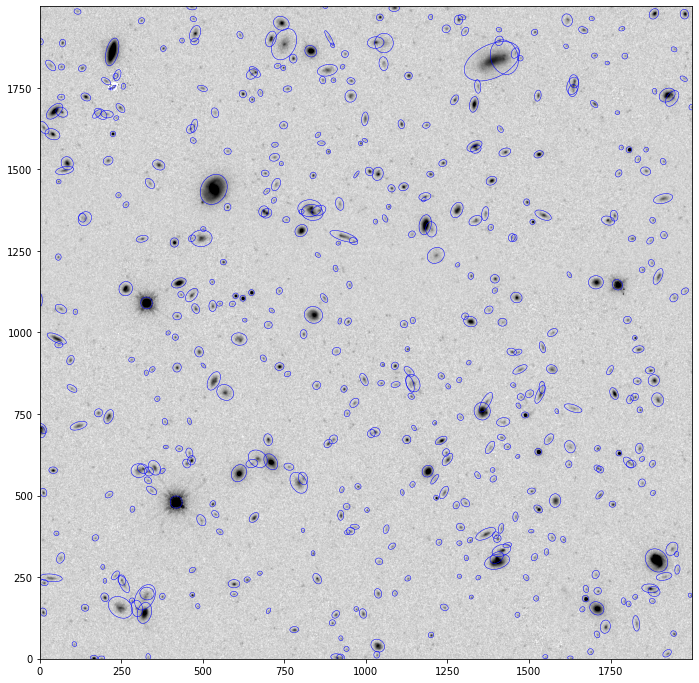

In [21]:
plt.figure(figsize=(12,12))
ax1=plt.subplot(111)
ax1.imshow(data,cmap='gray_r',norm=norm,origin='lower')
cat.plot_kron_apertures(axes=ax1, color='blue', lw=0.5,origin=(-1,-1))

In [22]:
bsize=cat.bbox[9].shape
cutout=cat.make_cutouts(bsize)[9].data
cutout

array([[ 2.55741947e-03,  4.81727096e-04,  1.45836675e-03,
         3.30154621e-03,  1.95174874e-03,  1.25114201e-03,
         5.38086426e-03,  8.17802921e-03,  1.46353319e-02,
         1.21996077e-02,  9.71765071e-03,  1.02342507e-02,
         6.58000354e-03,  7.63976993e-03,  1.01104612e-02,
         1.25315161e-02,  1.17575880e-02,  2.25671940e-02,
         1.86538622e-02,  1.35305924e-02,  1.66056678e-02,
         1.44532770e-02,  1.43864872e-02,  7.85850268e-03,
        -2.24096514e-03, -2.99661397e-03,  5.39501489e-05,
         7.44224666e-03,  6.93424605e-03],
       [ 2.77632941e-03, -2.30812933e-03,  6.04474859e-04,
         5.81230782e-03,  5.98670542e-03,  6.67778356e-03,
         1.15216374e-02,  1.48320980e-02,  2.18801554e-02,
         1.79160517e-02,  1.46402037e-02,  1.33513566e-02,
         1.08049018e-02,  1.67972241e-02,  2.35863402e-02,
         2.27757376e-02,  2.16798559e-02,  2.62668710e-02,
         2.61505488e-02,  2.12736949e-02,  2.05356032e-02,
         1.77

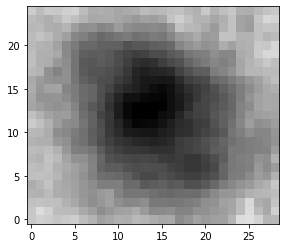

In [23]:
plt.imshow(cutout,cmap='gray_r',norm=norm,origin='lower')

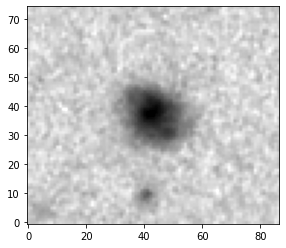

In [27]:
scale=3
size=tuple([scale*x for x in cat.bbox[9].shape])
cutout1=cat.make_cutouts(size)[9].data
plt.imshow(cutout1,cmap='gray_r',norm=norm,origin='lower')

接下来进行测光测光

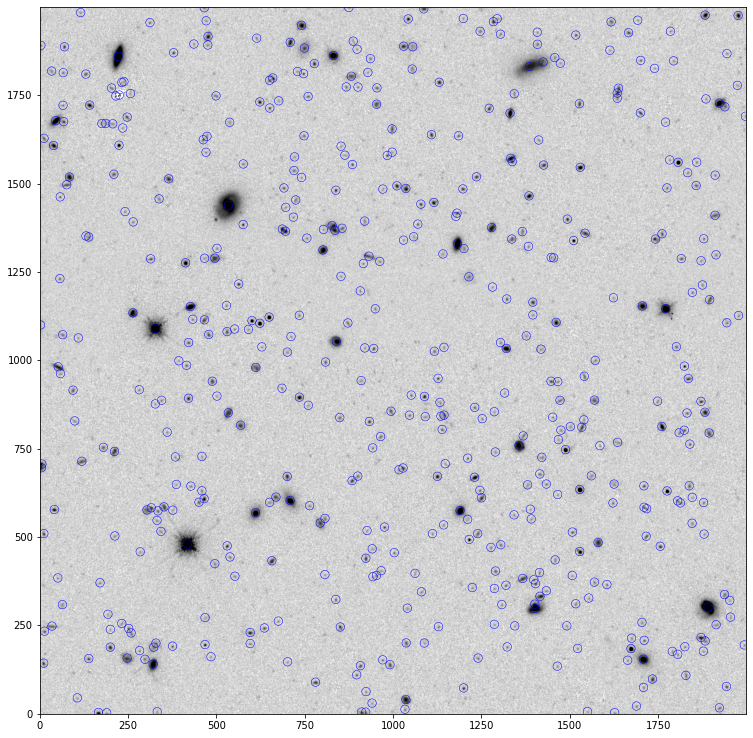

In [32]:
plt.figure(figsize=(13,13))
positions=cat.centroid+1
aperture=CircularAperture(positions,r=12) # in the literature r=6
annulus_aperture = CircularAnnulus(positions, r_in=30, r_out=40)

plt.imshow(data,cmap='gray_r',norm=norm,origin='lower')
ap_patches = aperture.plot(color='blue', lw=0.5,label='Photometry aperture')
#ann_patches = annulus_aperture.plot(color='red',lw=0.5,label='Background annulus')

In [37]:
phot_table = aperture_photometry(data, aperture)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,166.28163514567657,3.3507302132861314,8.341858390031964
2,189.46073063634924,2.312069428861964,1.1037439981454464
3,1627.002985513367,2.7539544247103507,0.885234025173959
4,332.4761020304555,5.305828923397874,1.1170656484250077
5,1550.1818783242798,6.006055410356685,0.7762059072814886
...,...,...,...
505,232.37439736186923,1786.3871372492326,2.015528557898279
506,238.24821253149528,1788.7088368089549,1.9428628331201359


In [1]:
#from photutils.aperture import ApertureStats
#aperstats = ApertureStats(data, annulus_aperture)
bkg_mean=sigma_clipped_stats(data, sigma=3.0)[0]
bkg_mean

NameError: name 'sigma_clipped_stats' is not defined

In [39]:
phot_bkgsub=phot_table['aperture_sum']-bkg_mean * aperture.area
phot_bkgsub.size

510

convert total flux into magnitude

In [40]:
#T=header['EXPTIME']
mag=-2.5*np.log10(phot_bkgsub)+25.946
mag

/var/folders/bz/_6mjvb0n3tb8n18mx13393380000gn/T/ipykernel_17492/87375897.py:2: RuntimeWarning: invalid value encountered in log10
  mag=-2.5*np.log10(phot_bkgsub)+25.946


23.66275135899523
25.999203564629585
26.28224961807466
25.984118634772134
26.45692403541658
25.398521100520185
25.00433881584659
25.74458680058141
...
23.428853647565475
23.838909555361084


计算half-light radius

In [41]:
Re=cat.fluxfrac_radius(0.5) #half-light radius
Re

<Quantity [ 2.61662158,  2.80430436,  2.65414806,  3.4562031 ,  3.04777068,
            3.36921835,  4.18767756,  3.01471748,  3.57281004,  6.87811202,
            3.1086983 ,  2.68291295,  2.65007407,  3.36534477,  3.07932726,
            3.95495767,  5.38807985,  5.95931703,  2.68676215,  7.95248696,
            3.71636567,  4.35975657,  2.89140893,  4.74238988,  3.72182603,
           10.74614934,  9.96880279,  2.85154803,  2.41646878,  3.1522309 ,
            3.44468167,  3.79717986,  2.72504214,  2.78360983,  3.317693  ,
            2.30900951,  3.2577848 ,  2.57772544,  3.86163014,  2.85330666,
            2.77924438,  2.87699169,  2.68336177,  2.12016839,  2.38725352,
            4.76448106,  3.19268961,  3.80529981,  3.32020448,  3.60489525,
            4.38985221,  3.84300105,  2.64996349,  4.4671773 ,  3.16689694,
            7.97012992,  3.08033671,  3.26317131,  2.94771728,  7.22029436,
            2.46522297,  5.17074649,  4.85839976,  2.67149164, 11.11071095,
            

(0.0, 18.0)

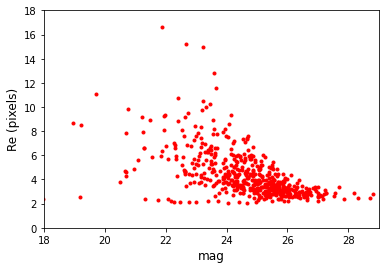

In [451]:
plt.plot(mag, Re, 'r.')
plt.xlabel('mag',fontsize=12)
plt.ylabel('Re (pixels)',fontsize=12)
plt.xlim(18,29)
plt.ylim(0,18)

生成星系源表（catalog）, 包含每个星系的基本参数： 比如源的id (label), 坐标 (xcentroid，ycentroid); 椭率（ellipticity）；方位角（orientation）;  面积（area)，背景数值（bkg_mean）; 总流量（phot_bkgsub）；半光半径（Re）; magnitude    例如：

In [42]:
#np.savetxt('galaxy_catalog.txt',np.transpose((cat.label, cat.xcentroid, cat.ycentroid, cat.ellipticity, cat.orientation, cat.area, bkg_mean, phot_bkgsub, Re, mag)), fmt='%3d %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f ' )
np.savetxt('galaxy_catalog.txt',np.transpose((cat.label,cat.xcentroid,cat.ycentroid,cat.ellipticity,cat.orientation,cat.area,phot_bkgsub,Re,mag)),fmt='%3d %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f')

生成image cutout 产品  比如 gal3.fits

In [45]:
for i in cat.label-1:
    bsize=cat.bbox[i].shape
    scale=5
    size=tuple([scale*x for x in cat.bbox[i].shape])
    cutout=cat.make_cutouts(size)[i].data
    fits.writeto('gal'+str(i+1)+'.fits',cutout.data,header=header,overwrite=True)  

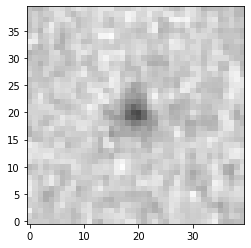

In [47]:
cutout=fits.open('gal105.fits')[0].data
plt.imshow(cutout,cmap='gray_r',norm=norm,origin='lower')

作业： 对于给定图像。
  
      1. Plot mag_re relation. x轴为mag, y轴为Re(half-light radius)（jpg格式）
        
      2. 生成包含所有源的catalog，同时每个星系需包含必要的参数，例如: id, x, y, ellipticity, area, Re, mag等等  (.txt格式)
      
      3.对于每个星系，请生成相应的image cutout （fits 格式）, 确保图像足够大，来包括整个星系和附近的sky。 将所有图像打包。
      
      4. （选作）对于每个星系，请生成相应的deblended segmentation cutout image. 然后将每个image cutout 属于目标星系的那部分pixels值修改为0 （这种图像可以被用来当作mask image）

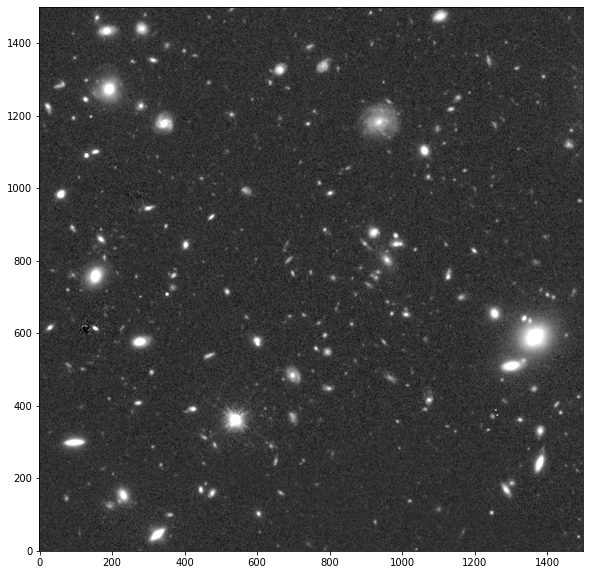

In [48]:
plt.figure(figsize=(10,10))
data1=fits.open('hst_egs.fits')[0].data
plt.imshow(data1,cmap='gray',norm=norm,origin='lower')